# Demo notebook showing arbok functionalities

This is a simple demo notebook containing the core functionalities of arbok

### Importing qm and arbok module

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.simulate.credentials import create_credentials
from qm import SimulationConfig

2023-07-17 17:10:56,368 - qm - INFO     - Starting session: e3ff1e7d-aa45-416a-a83b-3a71d595cca5


In [2]:
from arbok.core.sequence import Sequence
from arbok.core.sample import Sample

from arbok.samples.sunshine.readout.other_ST_read import OtherStReadout
from arbok.samples.sunshine.initialization.mixed_down_up_init import (
    MixedDownUpInit
)
from arbok.samples.sunshine.control.smart_Y import SmartY
from arbok.samples.sunshine.control.smart_swap import SmartSwap
from arbok.samples.sunshine.configs.rf2v_config import rf2v_config

### Instanciating Arbok modules

Firstly we instanciate `Sequence` objects describing initialization and readout

In [3]:
sunshine = Sample('sunshine', rf2v_config)

In [4]:
smart_Y = SmartY('smartY')
smart_swap12 = SmartSwap('smartSwap12')
smart_swap23 = SmartSwap('smartSwap32')
duInit = MixedDownUpInit('duInit')
stReadout = OtherStReadout('stReadout')

Added unit_amp successfully!
Added amp successfully!
Added smart_cycles successfully!


Next a `Sample` object is created containing the device config. With this we can create an empty `Sequence` that we will populate with other sequences in the following

In [5]:
CYY = Sequence('CYY', sample = sunshine)
MEAS = Sequence('MEAS', sample = sunshine)

Note how parameters that have already been defined in 'qh' are skipped.

In [6]:
CYY.add_subsequence(smart_swap12)
CYY.add_subsequence(smart_Y)
CYY.add_subsequence(smart_swap23)

In [7]:
MEAS.add_subsequence(duInit)
MEAS.add_subsequence(CYY)
MEAS.add_subsequence(stReadout)

Hereby the QCoDeS `Parameter`s describing the respective sequenes are referenced
in the containing `Sequence`. Therefore changes in the subsequences take effect 
in the merged sequence

In [8]:
MEAS.CYY.smartSwap12.root_instrument

<Sequence: MEAS>

### Simulating Sequences

The entire sequence can now be simulated. Note that 'tInitLoadMixed' and 'tPreControl' have been reduced for the sake of visibility.

2023-07-17 17:10:59,295 - qm - INFO     - Performing health check
2023-07-17 17:11:00,118 - qm - INFO     - Health check passed
STREAMING
2023-07-17 17:11:00,877 - qm - INFO     - Simulating program


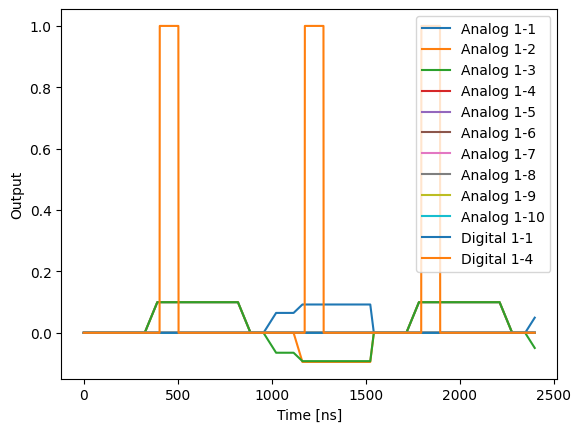

In [9]:
MEAS.CYY.smartSwap12.tWait(int(192))
#job = MEAS.CYY.smartSwap12.run_remote_simulation(duration = 2000)
job = MEAS.stReadout.run_remote_simulation(duration = 600)

In [10]:
MEAS.stReadout.ref2.__dict__

{'name': 'ref2_',
 'sequence': <OtherStReadout: stReadout>,
 'read_label': 'SDC',
 'threshold': 0,
 'read_I': <qm.qua._dsl._Variable at 0x1fb6e5c0450>,
 'read_Q': <qm.qua._dsl._Variable at 0x1fb6e5c0b90>,
 'read': <qm.qua._dsl._Variable at 0x1fb6e5c0cd0>,
 'state': <qm.qua._dsl._Variable at 0x1fb6e5c0e10>,
 'read_I_stream': <qm.qua._dsl._ResultSource at 0x1fb44a4db10>,
 'read_Q_stream': <qm.qua._dsl._ResultSource at 0x1fb6e5c15d0>,
 'read_stream': <qm.qua._dsl._ResultSource at 0x1fb6e5c1690>,
 'state_stream': <qm.qua._dsl._ResultSource at 0x1fb6e5c1810>,
 'chopRef_stream': <qm.qua._dsl._ResultSource at 0x1fb6e5c1750>,
 'chopN': <qm.qua._dsl._Variable at 0x1fb6e5c1190>,
 'chopRef': <qm.qua._dsl._Variable at 0x1fb6e5c13d0>}

In [11]:
samples = job.get_simulated_samples()

In [12]:
job.result_handles.__dict__

{'_job_id': '1689321258414',
 '_service': <qm.api.job_result_api.JobResultServiceApi at 0x1fb6ebc7410>,
 '_store': <qm.persistence.SimpleFileStore at 0x1fb6e10d490>,
 '_schema': JobResultSchema(items={'ref2_read_I': JobResultItemSchema(name='ref2_read_I', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_read_Q': JobResultItemSchema(name='ref2_read_Q', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_read': JobResultItemSchema(name='ref2_read', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_chopRef': JobResultItemSchema(name='ref2_chopRef', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_state': JobResultItemSchema(name='ref2_state', dtype=[['value', 'bool8']], shape=(1,), is_single=False, expected_count=-1), 'read_read_I': JobResultItemSchema(name='read_read_I', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), '

In [28]:
job.result_handles.diff_state.fetch_all()['value']

array([False])

### Using the `Sequence` in the quantify-core library

In [13]:
import quantify_core.data.handling as dh
from quantify_core.measurement import MeasurementControl

In [14]:
dh.set_datadir(dh.default_datadir())

Data will be saved in:
C:\Users\z5440260\quantify-data


In [15]:
meas_ctrl = MeasurementControl('meas_ctrl')

In [16]:
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [17]:
# plotmon = pqm.PlotMonitor_pyqt("plotmon")
# insmon = InstrumentMonitor("InstrumentMonitor")
# meas_ctrl.instr_plotmon(plotmon.name)

In [18]:
import datetime

MEAS.stReadout.add_parameter(
    name = 'dummy_read',
    unit = '',
    get_cmd = lambda: np.cos(datetime.datetime.now().microsecond*1e-4)
)

In [19]:
meas_ctrl.settables([
    MEAS.CYY.smartSwap12.tWait, 
    MEAS.CYY.smartSwap12.vControlSWAP_J1
])
meas_ctrl.setpoints_grid([
    range(180,220), 
    range(4,2000)
])

meas_ctrl.gettables(MEAS.stReadout.dummy_read)
#dset = meas_ctrl.run(name="Frequency sweep")

Gettables need to be `ParameterWithSetpoints`. This takes an arbitrary amount of 1D setpoint arrays (sizes (n), (m), (k)) and returns (n,m,k) get array.

In [20]:
#meas_ctrl.run()

In [21]:
meas_ctrl._settable_pars[0].root_instrument

<Sequence: MEAS>

In [22]:
MEAS.CYY.smartSwap12.tControlRamp

<arbok.core.sequence_parameter.SequenceParameter: tControlRamp at 2179397806288>

In [23]:
import datetime

In [24]:
datetime.datetime.now().microsecond

731617